Clear memory

In [1]:
%reset -f
import gc
gc.collect()

0

### Import libraries

In [2]:
import pandas as pd
import seaborn as sns
import optuna as opt
import warnings, json
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=DeprecationWarning)
opt.logging.set_verbosity(opt.logging.WARNING)
%matplotlib inline

In [3]:
from sklearn.linear_model import ElasticNet, Ridge, Lasso, LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scripts import *

# Loading datasets

In [4]:
df_train = pd.read_csv('data/train.csv', delimiter=',', index_col='Id', encoding='utf-8')
df_test = pd.read_csv('data/test.csv', delimiter=',', index_col='Id', encoding='utf-8')

### Get the general info of the train data

In [5]:
df_train = describe_dataframe(df_train, delete_duplicates=True)

First 5 rows of the DataFrame:


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


________________________________________________________________________________

Shape of the DataFrame: (1460, 80)
________________________________________________________________________________

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     146

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


________________________________________________________________________________

Missing values per column:


MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

Total missing values: 7829
________________________________________________________________________________

Duplicate rows: 0.0%
________________________________________________________________________________

No duplicate rows to remove.
________________________________________________________________________________

Unique values per column:


MSSubClass         15
MSZoning            5
LotFrontage       110
LotArea          1073
Street              2
Alley               2
LotShape            4
LandContour         4
Utilities           2
LotConfig           5
LandSlope           3
Neighborhood       25
Condition1          9
Condition2          8
BldgType            5
HouseStyle          8
OverallQual        10
OverallCond         9
YearBuilt         112
YearRemodAdd       61
RoofStyle           6
RoofMatl            8
Exterior1st        15
Exterior2nd        16
MasVnrType          3
MasVnrArea        327
ExterQual           4
ExterCond           5
Foundation          6
BsmtQual            4
BsmtCond            4
BsmtExposure        4
BsmtFinType1        6
BsmtFinSF1        637
BsmtFinType2        6
BsmtFinSF2        144
BsmtUnfSF         780
TotalBsmtSF       721
Heating             6
HeatingQC           5
CentralAir          2
Electrical          5
1stFlrSF          753
2ndFlrSF          417
LowQualFinSF       24
GrLivArea 

### Get the general info of the test data

In [6]:
df_test = describe_dataframe(df_test, delete_duplicates=True)

First 5 rows of the DataFrame:


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


________________________________________________________________________________

Shape of the DataFrame: (1459, 79)
________________________________________________________________________________

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 1461 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1459.0,57.378341,42.746880,20.0,20.00,50.0,70.00,190.0
LotFrontage,1232.0,68.580357,22.376841,21.0,58.00,67.0,80.00,200.0
LotArea,1459.0,9819.161069,4955.517327,1470.0,7391.00,9399.0,11517.50,56600.0
OverallQual,1459.0,6.078821,1.436812,1.0,5.00,6.0,7.00,10.0
OverallCond,1459.0,5.553804,1.113740,1.0,5.00,5.0,6.00,9.0
YearBuilt,1459.0,1971.357779,30.390071,1879.0,1953.00,1973.0,2001.00,2010.0
YearRemodAdd,1459.0,1983.662783,21.130467,1950.0,1963.00,1992.0,2004.00,2010.0
MasVnrArea,1444.0,100.709141,177.625900,0.0,0.00,0.0,164.00,1290.0
BsmtFinSF1,1458.0,439.203704,455.268042,0.0,0.00,350.5,753.50,4010.0
BsmtFinSF2,1458.0,52.619342,176.753926,0.0,0.00,0.0,0.00,1526.0


________________________________________________________________________________

Missing values per column:


MSSubClass          0
MSZoning            4
LotFrontage       227
LotArea             0
Street              0
Alley            1352
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType        894
MasVnrArea         15
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           44
BsmtCond           45
BsmtExposure       44
BsmtFinType1       42
BsmtFinSF1          1
BsmtFinType2       42
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

Total missing values: 7878
________________________________________________________________________________

Duplicate rows: 0.0%
________________________________________________________________________________

No duplicate rows to remove.
________________________________________________________________________________

Unique values per column:


MSSubClass         16
MSZoning            5
LotFrontage       115
LotArea          1106
Street              2
Alley               2
LotShape            4
LandContour         4
Utilities           1
LotConfig           5
LandSlope           3
Neighborhood       25
Condition1          9
Condition2          5
BldgType            5
HouseStyle          7
OverallQual        10
OverallCond         9
YearBuilt         106
YearRemodAdd       61
RoofStyle           6
RoofMatl            4
Exterior1st        13
Exterior2nd        15
MasVnrType          3
MasVnrArea        303
ExterQual           4
ExterCond           5
Foundation          6
BsmtQual            4
BsmtCond            4
BsmtExposure        4
BsmtFinType1        6
BsmtFinSF1        669
BsmtFinType2        6
BsmtFinSF2        161
BsmtUnfSF         793
TotalBsmtSF       736
Heating             4
HeatingQC           5
CentralAir          2
Electrical          4
1stFlrSF          789
2ndFlrSF          407
LowQualFinSF       15
GrLivArea 

# Handling Missing Data

Now we need to fill NA base on the description of the data

Save train abd test data columns names

In [7]:
train_columns = df_train.columns
test_columns = df_test.columns

### Handling first 10 columns

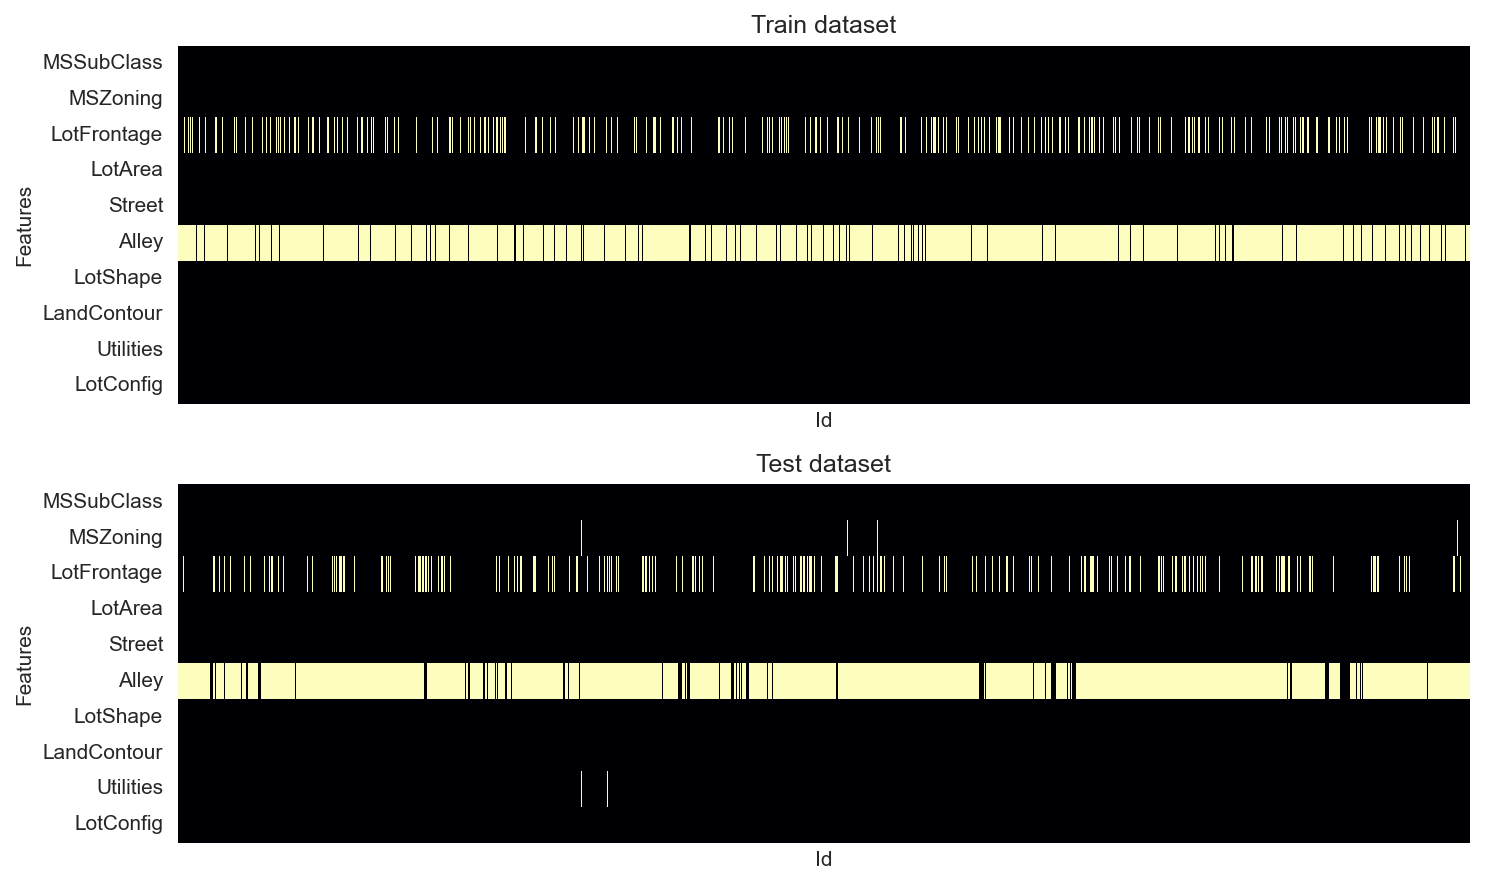

In [8]:
plot_missing_values(df_train[train_columns[:10]], df_test[test_columns[:10]])

In [9]:
df_train['MSZoning'].value_counts(dropna=False)

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

In [10]:
df_test['MSZoning'].value_counts(dropna=False)

MSZoning
RL         1114
RM          242
FV           74
C (all)      15
RH           10
NaN           4
Name: count, dtype: int64

In [11]:
df_test['MSZoning'] = df_test['MSZoning'].fillna('RL')

In [12]:
df_test['MSZoning'].value_counts(dropna=False)

MSZoning
RL         1118
RM          242
FV           74
C (all)      15
RH           10
Name: count, dtype: int64

In [13]:
df_train['Utilities'].value_counts(dropna=False)

Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64

In [14]:
df_test['Utilities'].value_counts(dropna=False)

Utilities
AllPub    1457
NaN          2
Name: count, dtype: int64

In [15]:
df_test['Utilities'] = df_test['Utilities'].fillna('AllPub')

In [16]:
df_train['Alley'].value_counts(dropna=False)

Alley
NaN     1369
Grvl      50
Pave      41
Name: count, dtype: int64

In [17]:
df_test['Alley'].value_counts(dropna=False)

Alley
NaN     1352
Grvl      70
Pave      37
Name: count, dtype: int64

In [18]:
df_test['Alley'] = df_test['Alley'].fillna('NA')
df_train['Alley'] = df_train['Alley'].fillna('NA')

In [19]:
df_test['LotFrontage'] = df_test['LotFrontage'].fillna(0.0)
df_train['LotFrontage'] = df_train['LotFrontage'].fillna(0.0)

### Handling second 10 columns

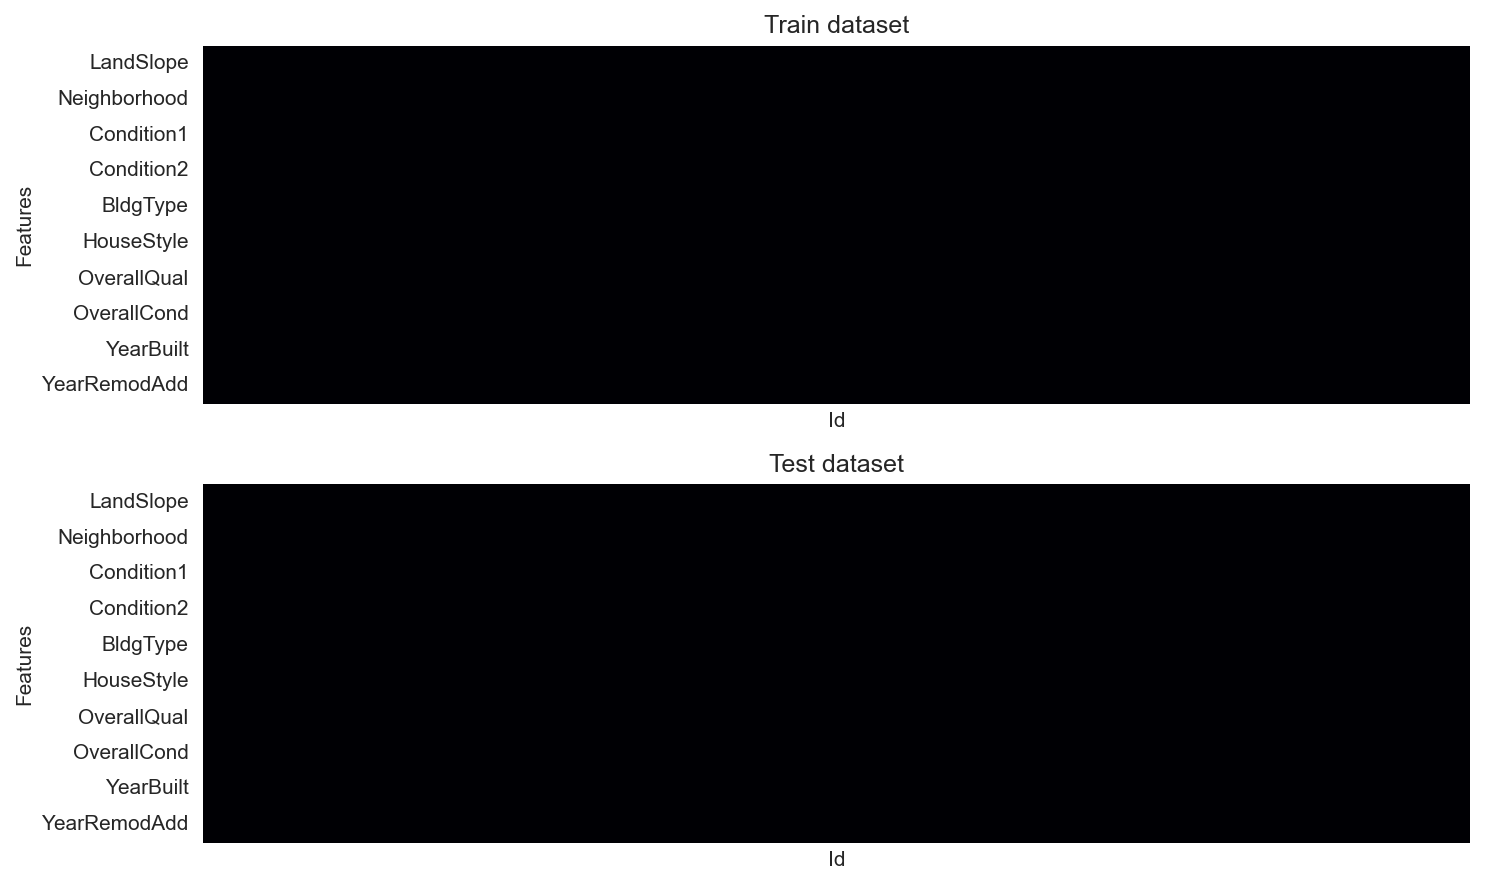

In [20]:
plot_missing_values(df_train[train_columns[10:20]], df_test[test_columns[10:20]])

There is no missing values here!


### Handling third 10 columns

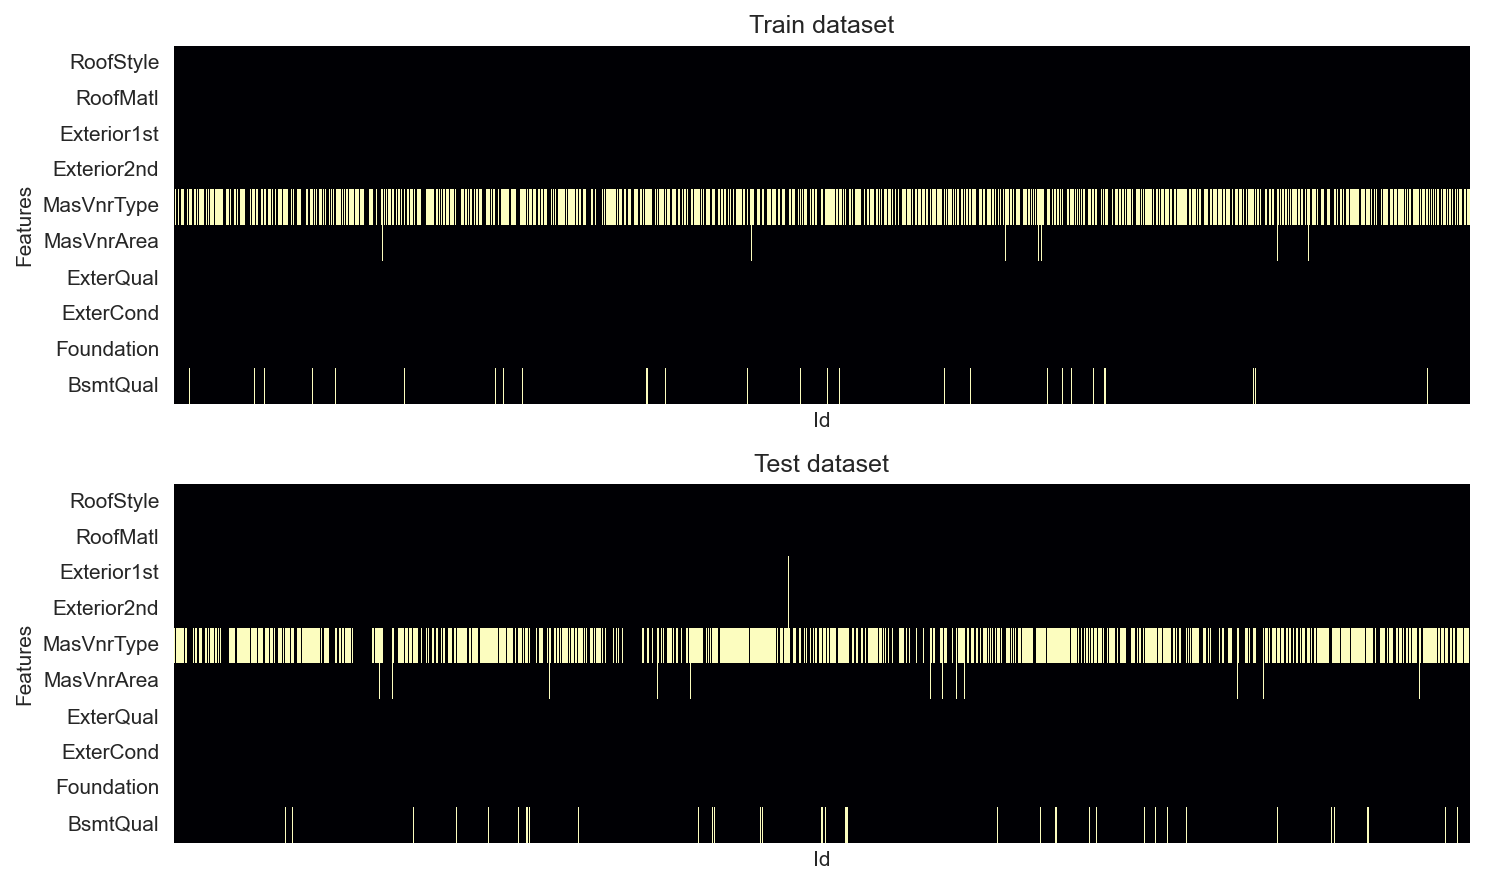

In [21]:
plot_missing_values(df_train[train_columns[20:30]], df_test[test_columns[20:30]])

In [22]:
df_train['Exterior1st'].value_counts(dropna=False)

Exterior1st
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: count, dtype: int64

In [23]:
df_test['Exterior1st'].value_counts(dropna=False)

Exterior1st
VinylSd    510
MetalSd    230
HdBoard    220
Wd Sdng    205
Plywood    113
CemntBd     65
BrkFace     37
WdShing     30
AsbShng     24
Stucco      18
BrkComm      4
AsphShn      1
NaN          1
CBlock       1
Name: count, dtype: int64

In [24]:
df_test['Exterior1st'] = df_test['Exterior1st'].fillna('VinylSd')

In [25]:
df_train['Exterior2nd'].value_counts(dropna=False)

Exterior2nd
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: count, dtype: int64

In [26]:
df_test[df_test['Exterior1st']=='VinylSd']['Exterior2nd'].value_counts(dropna=False)

Exterior2nd
VinylSd    503
Wd Shng      4
MetalSd      2
NaN          1
Wd Sdng      1
Name: count, dtype: int64

In [27]:
df_test['Exterior2nd'] = df_test['Exterior2nd'].fillna('VinylSd')

In [28]:
mask = (df_train['MasVnrArea'].isnull())
df_train.loc[mask, 'MasVnrType'] = df_train.loc[mask, 'MasVnrType'].fillna('None')

In [29]:
mask = (df_test['MasVnrArea'].isnull())
df_test.loc[mask, 'MasVnrType'] = df_test.loc[mask, 'MasVnrType'].fillna('None')

In [30]:
mask = (df_train['MasVnrArea']==0.0)
df_train.loc[mask, 'MasVnrType'] = 'None'

In [31]:
mask = (df_test['MasVnrArea']==0.0)
df_test.loc[mask, 'MasVnrType'] = 'None'

In [32]:
df_train[df_train['MasVnrType'].isnull()]['MasVnrArea']

Id
625     288.0
774       1.0
1231      1.0
1301    344.0
1335    312.0
Name: MasVnrArea, dtype: float64

In [33]:
df_train['MasVnrType'] = df_train['MasVnrType'].fillna('BrkFace')
df_test['MasVnrType'] = df_test['MasVnrType'].fillna('BrkFace')

In [34]:
df_train.loc[df_train['MasVnrType'] == 'None','MasVnrArea'] = 0.0
df_test.loc[df_test['MasVnrType'] == 'None','MasVnrArea'] = 0.0

### Handling fourth 10 columns

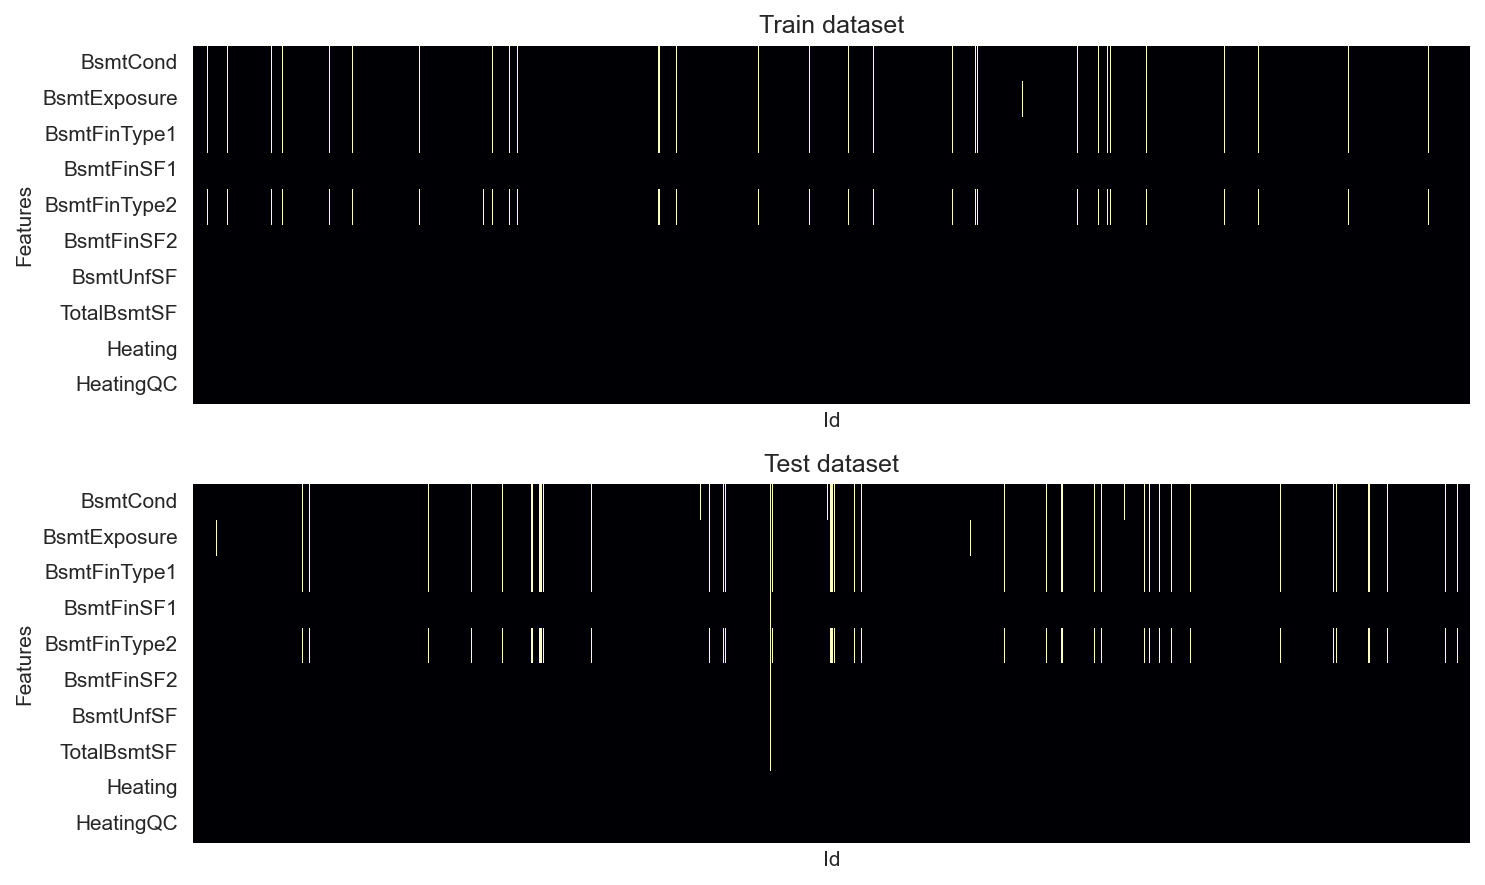

In [35]:
plot_missing_values(df_train[train_columns[30:40]], df_test[test_columns[30:40]])

In [36]:
df_train['BsmtQual'] = df_train['BsmtQual'].fillna('NA')
df_test['BsmtQual'] = df_test['BsmtQual'].fillna('NA')

In [37]:
df_train['BsmtCond'] = df_train['BsmtCond'].fillna('NA')
df_test['BsmtCond'] = df_test['BsmtCond'].fillna('NA')

In [38]:
df_train['BsmtExposure'] = df_train['BsmtExposure'].fillna('NA')
df_test['BsmtExposure'] = df_test['BsmtExposure'].fillna('NA')

In [39]:
df_train['BsmtFinType1'] = df_train['BsmtFinType1'].fillna('NA')
df_test['BsmtFinType1'] = df_test['BsmtFinType1'].fillna('NA')

In [40]:
df_train['BsmtFinType2'] = df_train['BsmtFinType2'].fillna('NA')
df_test['BsmtFinType2'] = df_test['BsmtFinType2'].fillna('NA')

In [41]:
df_test['BsmtFinSF1'] = df_test['BsmtFinSF1'].fillna(0.0)

In [42]:
df_test['BsmtFinSF2'] = df_test['BsmtFinSF2'].fillna(0.0)

In [43]:
df_test['BsmtUnfSF'] = df_test['BsmtUnfSF'].fillna(0.0)

In [44]:
df_test['TotalBsmtSF'] = df_test['TotalBsmtSF'].fillna(0.0)

### Handling fifth 10 columns

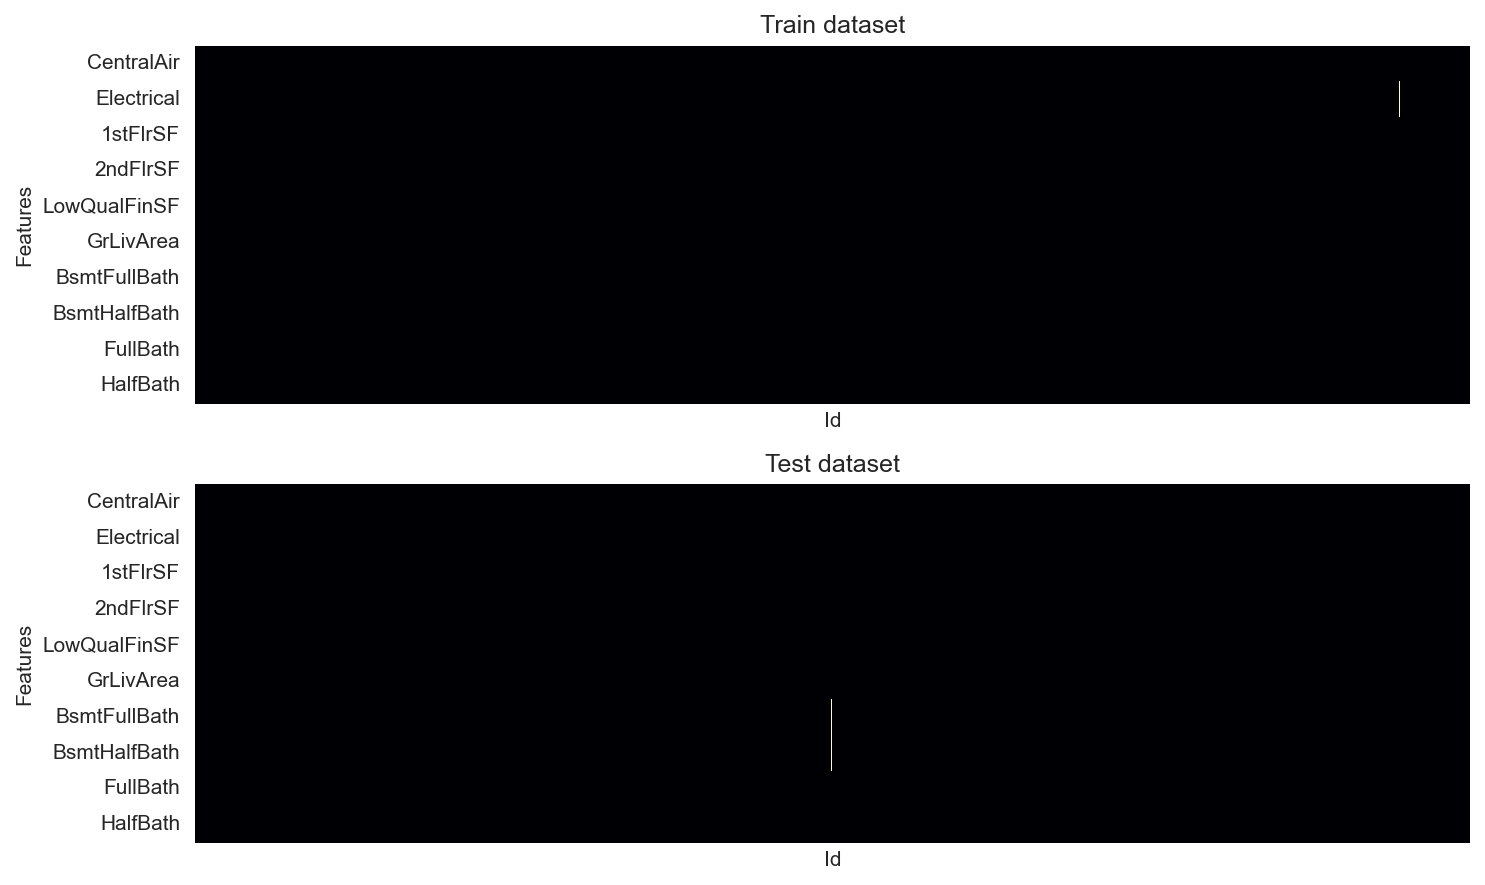

In [45]:
plot_missing_values(df_train[train_columns[40:50]], df_test[test_columns[40:50]])

In [46]:
df_train['Electrical'].value_counts(dropna=False)

Electrical
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: count, dtype: int64

In [47]:
df_train['Electrical'] = df_train['Electrical'].fillna('SBrkr')

In [48]:
df_test['BsmtFullBath'] = df_test['BsmtFullBath'].fillna(0.0)
df_test['BsmtHalfBath'] = df_test['BsmtHalfBath'].fillna(0.0)

### Handling sixth 10 columns

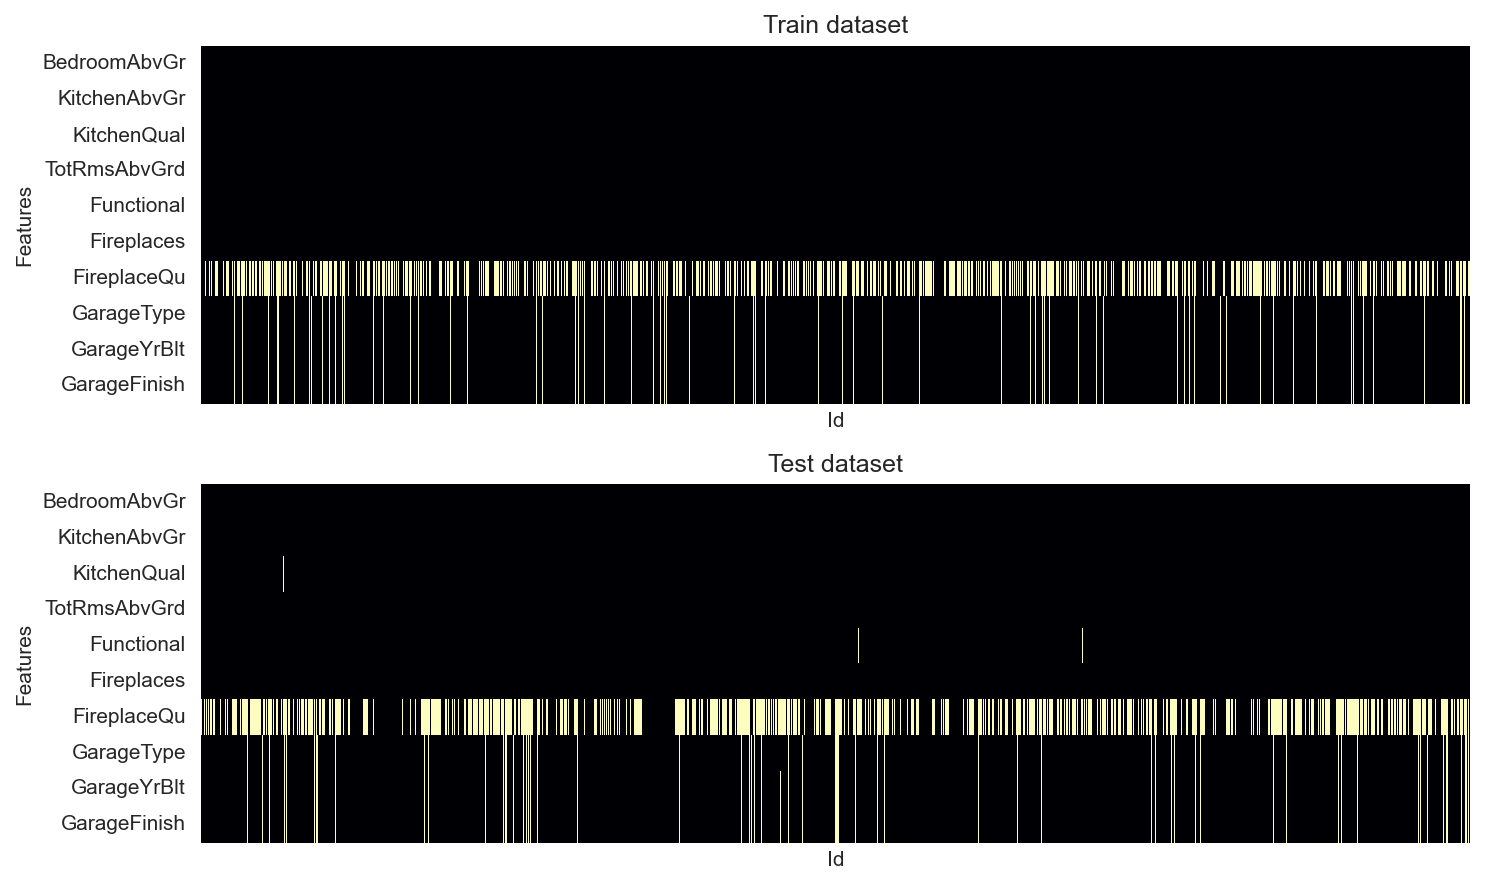

In [49]:
plot_missing_values(df_train[train_columns[50:60]], df_test[test_columns[50:60]])

In [50]:
df_train['FireplaceQu'] = df_train['FireplaceQu'].fillna('NA')
df_test['FireplaceQu'] = df_test['FireplaceQu'].fillna('NA')

In [51]:
df_train['GarageType'] = df_train['GarageType'].fillna('NA')
df_test['GarageType'] = df_test['GarageType'].fillna('NA')

In [52]:
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].fillna(-1)
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].fillna(-1)

In [53]:
df_test['KitchenQual'] = df_test['KitchenQual'].fillna('TA')

In [54]:
df_test['Functional'] = df_test['Functional'].fillna('Typ')

### Handling seventh 10 columns

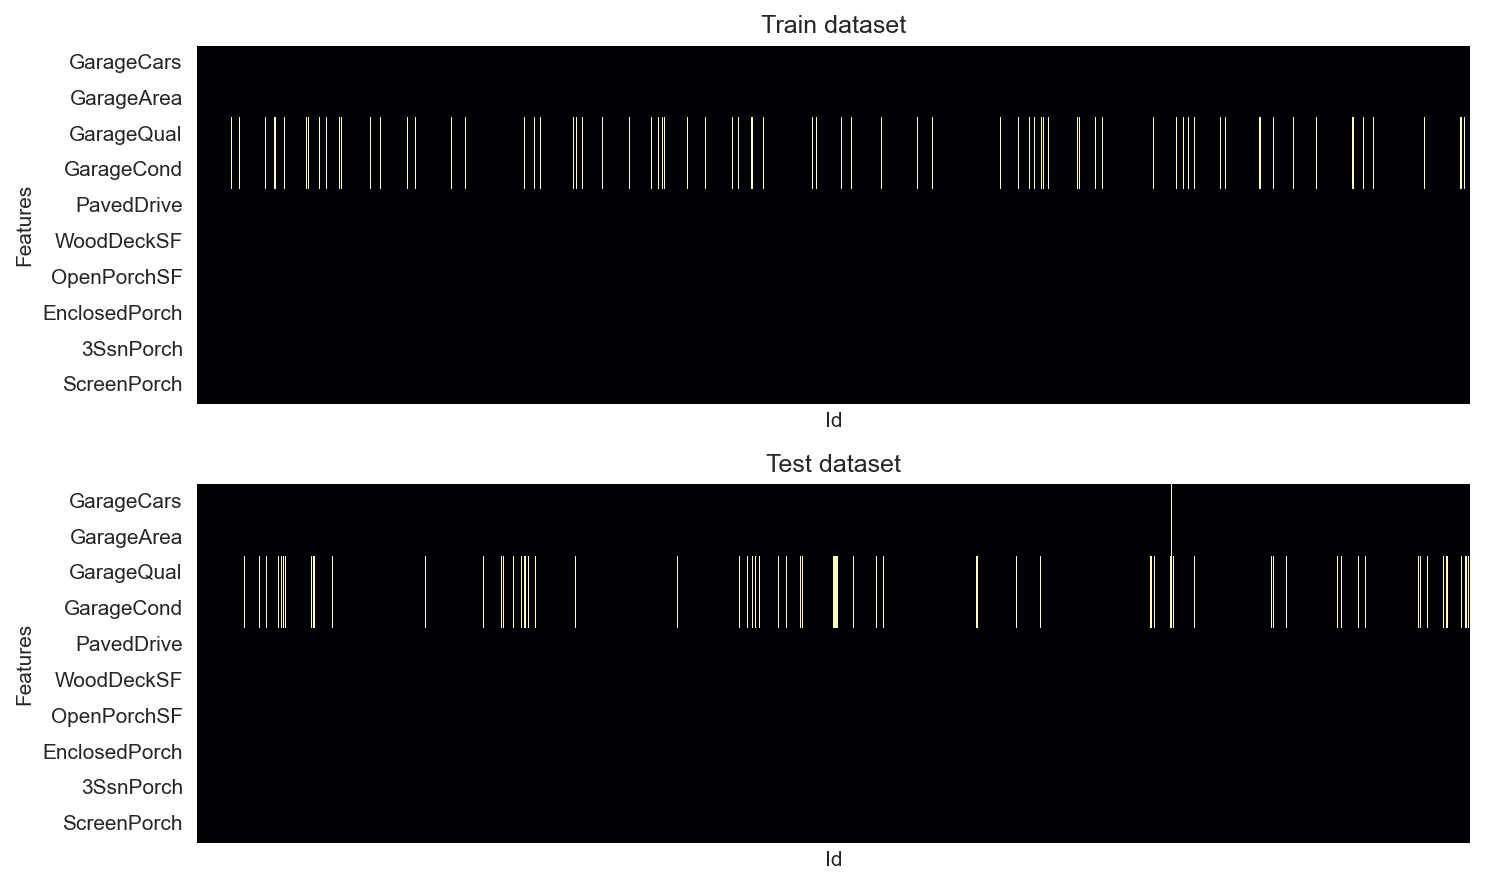

In [55]:
plot_missing_values(df_train[train_columns[60:70]], df_test[test_columns[60:70]])

In [56]:
df_train['GarageFinish'] = df_train['GarageFinish'].fillna('NA')
df_test['GarageFinish'] = df_test['GarageFinish'].fillna('NA')

In [57]:
df_train['GarageQual'] = df_train['GarageQual'].fillna('NA')
df_test['GarageQual'] = df_test['GarageQual'].fillna('NA')

In [58]:
df_train['GarageCond'] = df_train['GarageCond'].fillna('NA')
df_test['GarageCond'] = df_test['GarageCond'].fillna('NA')

In [59]:
df_test['GarageCars'] = df_test['GarageCars'].fillna(1.0)

In [60]:
df_test['GarageArea'] = df_test['GarageArea'].fillna(df_test.loc[df_test['GarageType']=='Detchd', 'GarageArea'].mean())

### Handling eighth 10 columns

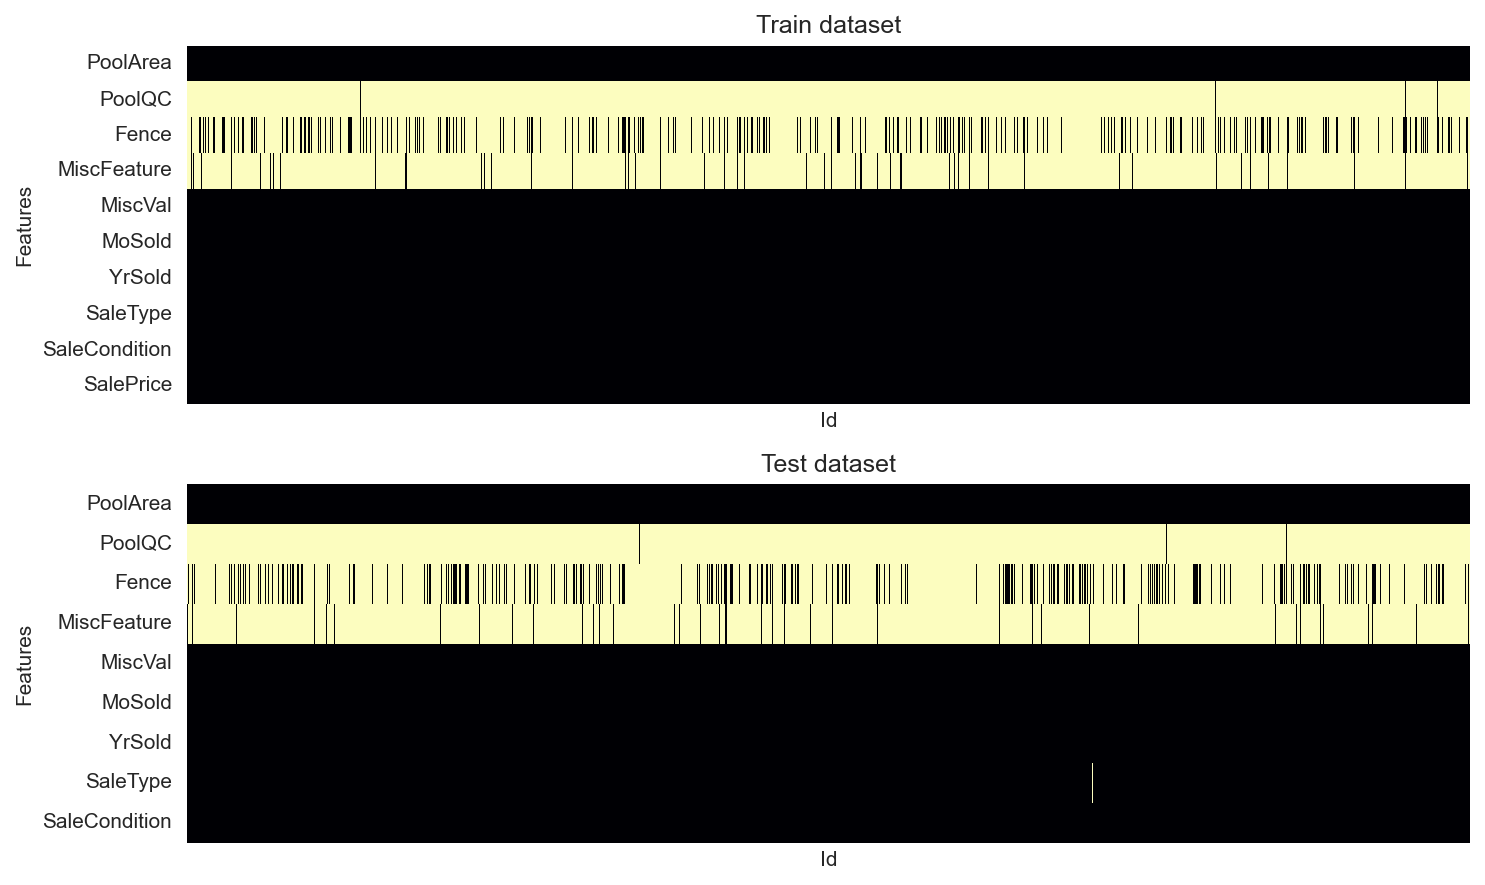

In [61]:
plot_missing_values(df_train[train_columns[70:]], df_test[test_columns[70:]])

In [62]:
df_train['PoolQC'] = df_train['PoolQC'].fillna('NA')
df_test['PoolQC'] = df_test['PoolQC'].fillna('NA')

In [63]:
df_train['Fence'] = df_train['Fence'].fillna('NA')
df_test['Fence'] = df_test['Fence'].fillna('NA')

In [64]:
df_train['MiscFeature'] = df_train['MiscFeature'].fillna('NA')
df_test['MiscFeature'] = df_test['MiscFeature'].fillna('NA')

In [65]:
df_test['SaleType'] = df_test['SaleType'].fillna('WD')

### Final check

In [66]:
print('Number of NA in train data:', df_train.isna().sum().sum())

Number of NA in train data: 0


In [67]:
print('Number of NA in test data:', df_test.isna().sum().sum())

Number of NA in test data: 0


Well done!

# Feature Type Conversion

Based on the description, choose features to be transformed to categorical data type. Usually it is date or class number. 'YearBuilt' is not added because it has too many unique values

In [68]:
cols = ['MSSubClass', 'MoSold', 'YrSold']

Transform selected features to categorical type

In [69]:
for col in cols:
    df_train[col] = df_train[col].astype('object')
    df_test[col] = df_test[col].astype('object')

Transform all numerical features to float

In [70]:
cols = df_test.select_dtypes(include=[np.number]).columns

for col in cols:
    df_train[col] = df_train[col].astype(np.float64)
    df_test[col] = df_test[col].astype(np.float64)

Define categorical and numerical features. Since we already have 70+ features and a lot of them are categorical, cardinality of 6 or more is considered as high cardinality

In [71]:
cat = df_train.select_dtypes(include=['object']).nunique()

cat_features_low = cat[cat<=5].index
cat_features_high = cat[cat>5].index

num_features = df_test.select_dtypes(include=[np.number]).columns

Categorical features with low cardinality

In [72]:
print(cat_features_low)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'BldgType', 'MasVnrType', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'GarageFinish', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'YrSold'],
      dtype='object')


Categorical features with high cardinality

In [73]:
print(cat_features_high)

Index(['MSSubClass', 'Neighborhood', 'Condition1', 'Condition2', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageQual', 'GarageCond', 'MoSold', 'SaleType',
       'SaleCondition'],
      dtype='object')


Numerical features

In [74]:
print(num_features)

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')


Define target variable

In [75]:
target = 'SalePrice'

# Feature Engineering 

## Removing outliers 

Since data has relatively small number of samples and large number of features, it is safer to remove outliers carefully by hand

First, plot relationships between numerical features and target variable

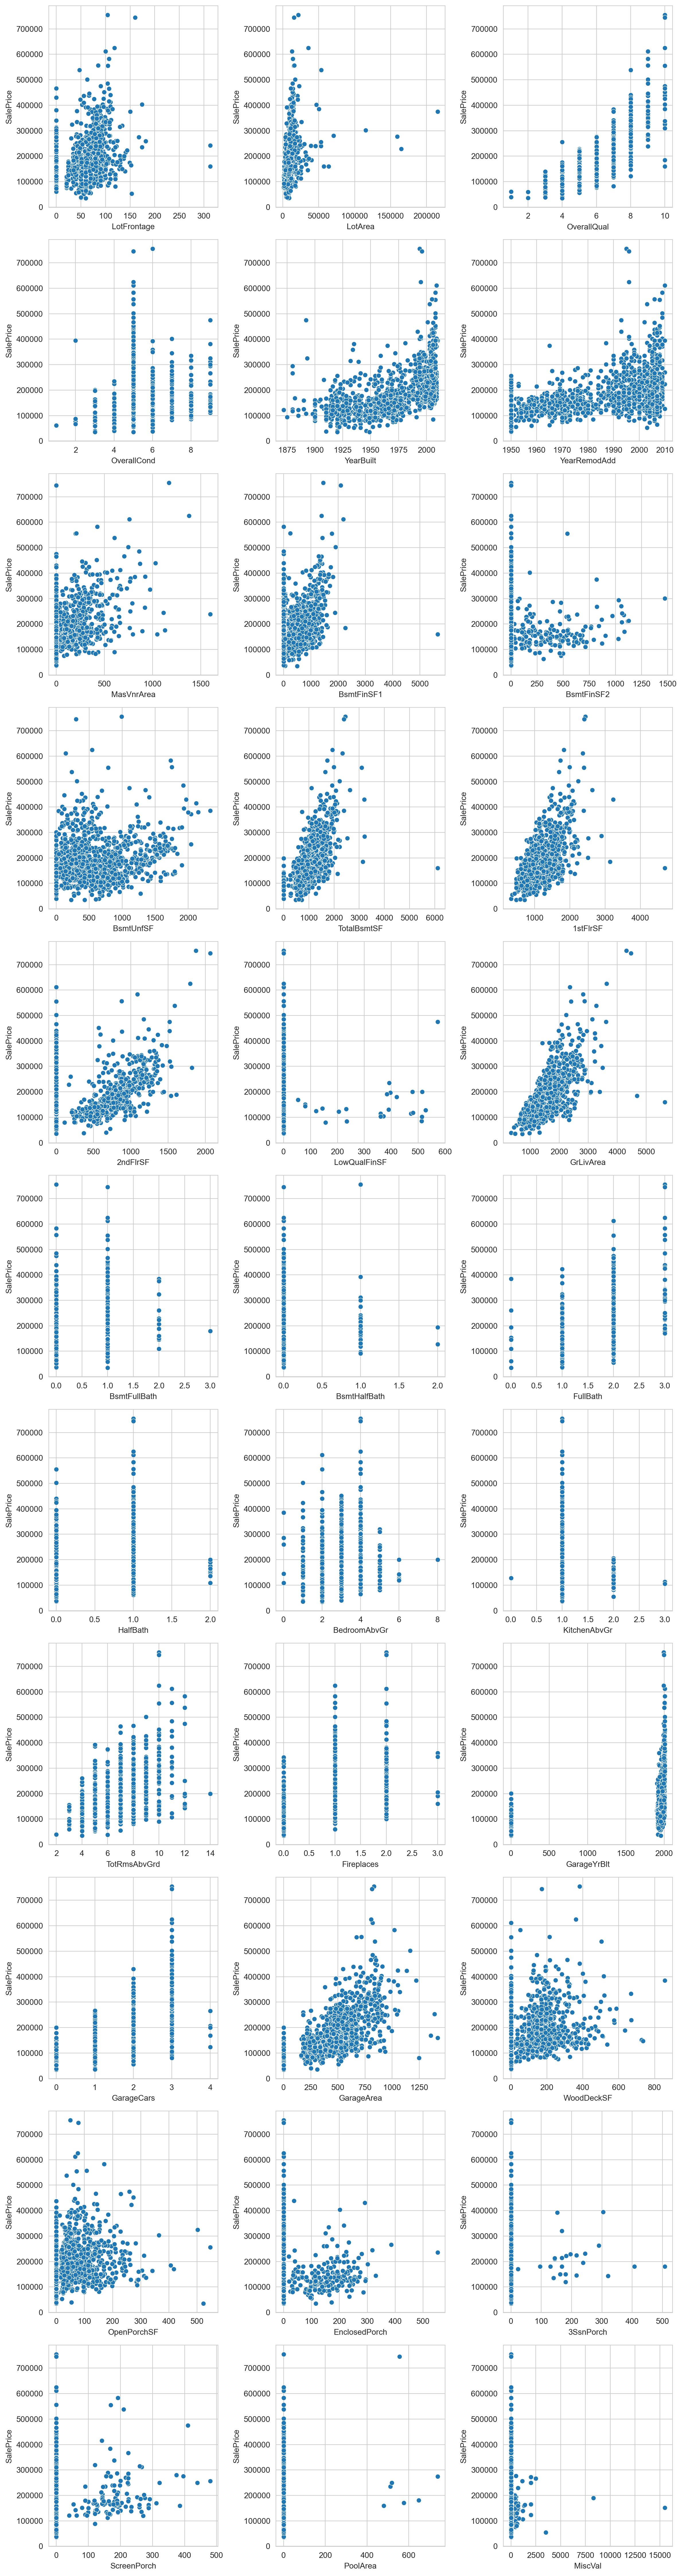

In [76]:
plt.figure(figsize=(12,45), dpi=200)
for i,c in enumerate(num_features):
    plt.subplot(11,3,i+1)
    sns.scatterplot(data=df_train, x=c, y=target)
plt.tight_layout()
plt.show()

Second, remove some very obvious outliers 

In [77]:
index = df_train[df_train['LotFrontage']>300].index
df_train = df_train.drop(index=index)

In [78]:
index = df_train[df_train['LotArea']>80000].index
df_train = df_train.drop(index=index)

In [79]:
index = df_train[df_train['BsmtFinSF2']>1250].index
df_train = df_train.drop(index=index)

In [80]:
index = df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index
df_train = df_train.drop(index=index)

In [81]:
index = df_train[df_train['EnclosedPorch']>500].index
df_train = df_train.drop(index=index)

In [82]:
index = df_train[df_train['MiscVal']>2600].index
df_train = df_train.drop(index=index)

In [83]:
index = df_train[df_train['SalePrice']>700000].index
df_train = df_train.drop(index=index)

## Split the data

In [84]:
X_train = df_train.drop(columns=['SalePrice'])
X_test = df_test.copy(deep=True)
y_train = df_train['SalePrice'].copy(deep=True)

## Correct distributions

### Correct target variable distribution

Plot the target variable distribution with different transformations and compare with normal distribution

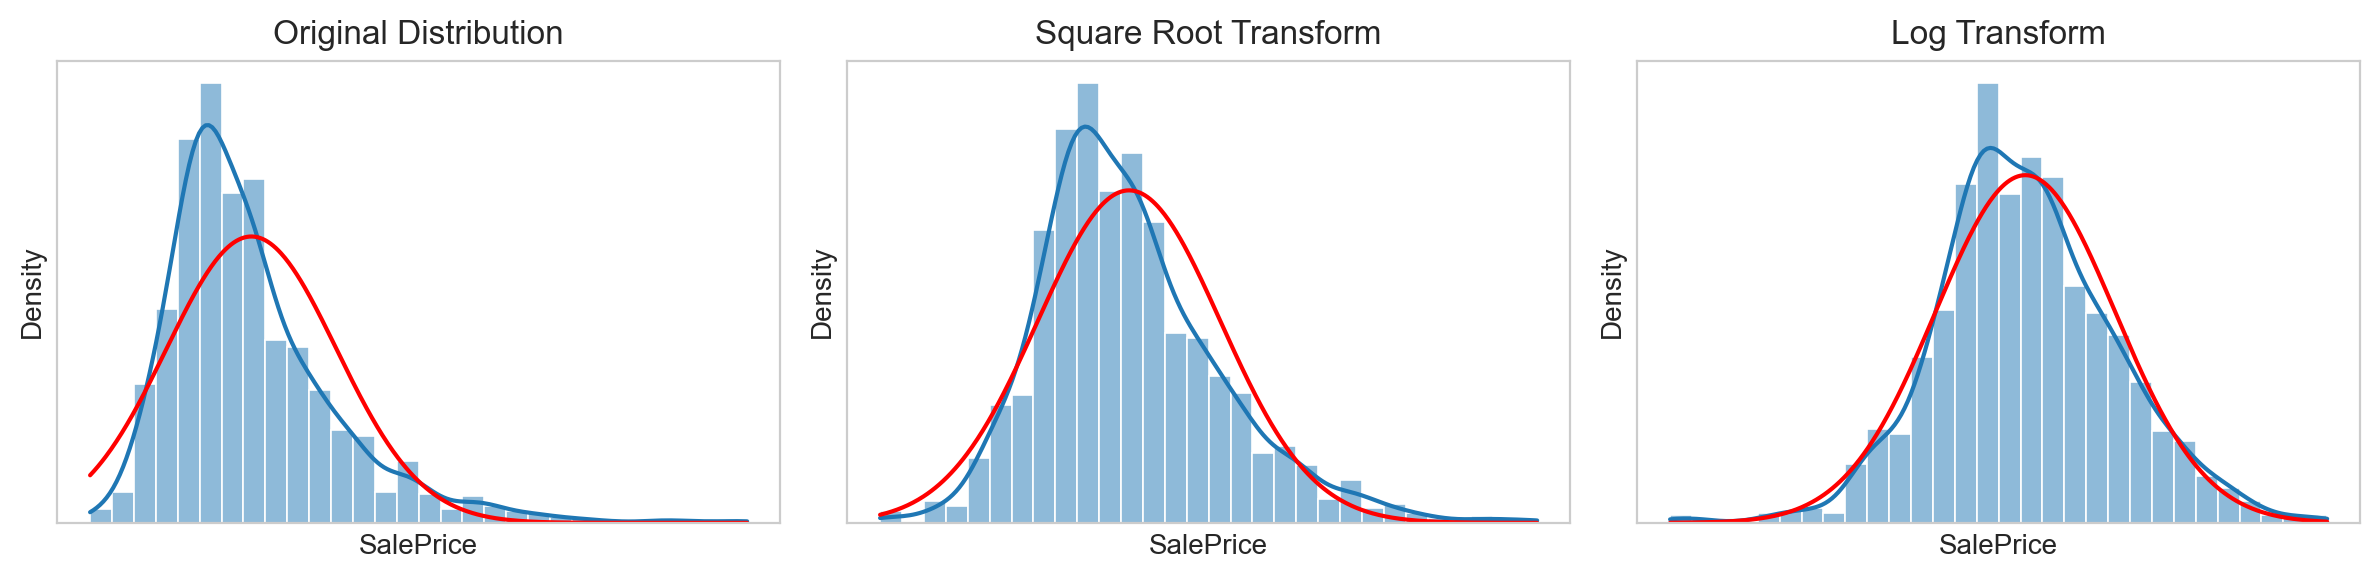

In [85]:
plot_distributions_with_transforms(y_train)

The logarithmic transformation best corrects the skewed distribution of the target variable

In [86]:
y_train = np.log(y_train)

### Correct numeric features distributions 

Calculate the skewness of each feature distribution

In [87]:
train_skew = X_train[num_features].skew().abs()
test_skew = X_test[num_features].skew().abs()

Save train and test skewness value to the dataframe

In [88]:
skews = pd.DataFrame({'Train': train_skew, 'Test': test_skew})
skews.sort_values(by=['Train', 'Test'], ascending=False).head(10)

,Train,Test
PoolArea,19.449321,20.196888
3SsnPorch,10.253585,12.524216
MiscVal,9.424435,20.075188
LowQualFinSF,9.232795,16.167254
KitchenAbvGr,4.545033,4.079055
BsmtHalfBath,4.178311,3.782976
BsmtFinSF2,4.147971,4.042954
ScreenPorch,4.099164,3.788244
LotArea,4.012861,3.115217
GarageYrBlt,3.875931,3.952040


Assume that the skewness is high if its value is greater than 0.5. Save features names with high skewness to another variable

In [89]:
skew_cols = skews[(skews['Test']>0.5) & (skews['Train']>0.5)].index
skew_cols

Index(['LotArea', 'YearBuilt', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal'],
      dtype='object')

Use Yeo-Johnson transform to correct distributions

In [90]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)
pt.fit(X_train[skew_cols])

X_train[skew_cols] = pt.transform(X_train[skew_cols])
X_test[skew_cols] = pt.transform(X_test[skew_cols])

## Numeric Feature Scaling

Use Standard Scaler to standardize distributions

In [91]:
scaler = StandardScaler()
scaler.fit(X_train[num_features])

X_train[num_features] = scaler.transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

## Categorical Feature Encoding

### One-hot encoding for low cardinality categorical features

Concatenate train and test dataframes

In [92]:
X_train['dataset'] = 'train'
X_test['dataset'] = 'test'

combined = pd.concat([X_train, X_test], axis=0)

combined.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,dataset
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,0.238811,-0.175328,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.665592,-0.51696,1.150214,0.880045,Gable,CompShg,VinylSd,VinylSd,BrkFace,1.233327,Gd,TA,PConc,Gd,TA,No,GLQ,0.808136,Unf,-0.355202,-0.892396,-0.425359,GasA,Ex,Y,SBrkr,-0.805232,1.177131,-0.13264,0.543420,1.183810,-0.240397,0.803744,1.286187,0.169720,-0.170351,Gd,0.963625,Typ,-1.022362,NA,Attchd,0.356008,RFn,0.314929,0.361480,TA,TA,Y,-0.948715,0.844738,-0.407588,-0.129914,-0.295327,-0.052668,NA,NA,NA,-0.183291,2,2008,WD,Normal,train
2,20,RL,0.694779,0.091579,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,-0.064087,2.17844,0.005814,-0.426967,Gable,CompShg,MetalSd,MetalSd,None,-0.817637,TA,TA,CBlock,Gd,TA,Gd,ALQ,1.022583,Unf,-0.355202,-0.439150,0.540463,GasA,Ex,Y,SBrkr,0.443115,-0.866699,-0.13264,-0.391028,-0.835256,4.159783,0.803744,-0.772859,0.169720,-0.170351,TA,-0.228348,Typ,0.797958,TA,Attchd,0.227594,RFn,0.314929,-0.053844,TA,TA,Y,1.216545,-1.069867,-0.407588,-0.129914,-0.295327,-0.052668,NA,NA,NA,-0.183291,5,2007,WD,Normal,train
3,60,RL,0.330004,0.435198,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.665592,-0.51696,1.053740,0.831637,Gable,CompShg,VinylSd,VinylSd,BrkFace,1.196575,Gd,TA,PConc,Gd,TA,Mn,GLQ,0.581368,Unf,-0.355202,-0.052647,-0.268046,GasA,Ex,Y,SBrkr,-0.572533,1.179740,-0.13264,0.680040,1.183810,-0.240397,0.803744,1.286187,0.169720,-0.170351,Gd,-0.228348,Typ,0.797958,TA,Attchd,0.346427,RFn,0.314929,0.644655,TA,TA,Y,-0.948715,0.671459,-0.407588,-0.129914,-0.295327,-0.052668,NA,NA,NA,-0.183291,9,2008,WD,Normal,train
4,70,RL,0.086821,0.080492,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,0.665592,-0.51696,-1.627546,-0.717414,Gable,CompShg,Wd Sdng,Wd Shng,None,-0.817637,TA,TA,BrkTil,TA,Gd,No,ALQ,0.151219,Unf,-0.355202,0.178947,-0.675839,GasA,Gd,Y,SBrkr,-0.432003,1.154136,-0.13264,0.556224,1.183810,-0.240397,-1.020768,-0.772859,0.169720,-0.170351,Gd,0.401053,Typ,0.797958,Gd,Detchd,0.332076,Unf,1.654302,0.805121,TA,TA,Y,-0.948715,0.587573,2.456679,-0.129914,-0.295327,-0.052668,NA,NA,NA,-0.183291,2,2006,WD,Abnorml,train
5,60,RL,0.816371,0.974408,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,1.395271,-0.51696,1.006263,0.734822,Gable,CompShg,VinylSd,VinylSd,BrkFace,1.335387,Gd,TA,PConc,Gd,TA,Av,GLQ,0.761026,Unf,-0.355202,0.073011,0.269310,GasA,Ex,Y,SBrkr,0.131257,1.215799,-0.13264,1.342274,1.183810,-0.240397,0.803744,1.286187,1.396798,-0.170351,Gd,1.472814,Typ,0.797958,TA,Attchd,0.341640,RFn,1.654302,1.720722,TA,TA,Y,1.083168,0.994702,-0.407588,-0.129914,-0.295327,-0.052668,NA,NA,NA,-0.183291,12,2008,WD,Normal,train


Perform one-hot encoding. First category has to be dropped to avoid dummy trap

In [93]:
combined = pd.get_dummies(combined, columns=cat_features_low, drop_first=True)

Split the data back

In [94]:
X_train = combined[combined['dataset'] == 'train'].drop(columns=['dataset'])
X_test = combined[combined['dataset'] == 'test'].drop(columns=['dataset'])

Delete "combined" to clear memory

In [95]:
del combined

### Frequency encoding for high cardinality categorical features

Important: frequencies have to be calculated on train data only

In [96]:
for i in cat_features_high:
    freqs = X_train[i].value_counts(normalize=True)

    X_train[i] = X_train[i].map(freqs)
    X_test[i] = X_test[i].map(freqs)
    X_test[i] = X_test[i].fillna(0)


Datasets are ready, transform them to numpy arrays

In [97]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# Modeling

Define cross validation

In [98]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

Select models to be trained

In [99]:
models = {
    'LinearRegression': LinearRegression(),
    'ElasticNet': ElasticNet(max_iter=3000),
    'Lasso': Lasso(max_iter=3000),
    'Ridge': Ridge(max_iter=3000),
    'KNN': KNeighborsRegressor(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'LGBM': LGBMRegressor(verbose=-1),
}

## Separate modelling

Define auxiliary dictionary with numbers of training trials

In [100]:
trials = {
    'LinearRegression': 1,
    'ElasticNet': 50,
    'Lasso': 20,
    'Ridge': 20,
    'KNN': 50,
    'DecisionTree': 500,
    'RandomForest': 500,
    'GradientBoosting': 500,
    'XGBoost': 500,
    'LGBM': 500,
}

Define parameters to tune and their limits for each model

In [101]:
params_grid = {
    'LinearRegression': {
        'fit_intercept': {'type': 'categorical', 'choices': [True]},
    },
    'ElasticNet':{
        'alpha': {'type': 'float', 'low': 1e-5, 'high': 10.0, 'log': True},
        'l1_ratio': {'type': 'float', 'low': 0.0, 'high': 1.0, 'log': False},
    },
    'Lasso':{
        'alpha': {'type': 'float', 'low': 1e-5, 'high': 10.0, 'log': True},
    },
    'Ridge': {
        'alpha': {'type': 'float', 'low': 1e-5, 'high': 1000.0, 'log': True},
    },
    'KNN': {
        'n_neighbors': {'type': 'int', 'low': 1, 'high': 50, 'step': 1},
    },
    'DecisionTree': {
        'criterion': {'type': 'categorical', 'choices': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']},
        'max_depth': {'type': 'int', 'low': 1, 'high': 50, 'step': 1},
        'min_samples_split': {'type': 'int', 'low': 2, 'high': 20, 'step': 1},
        'min_samples_leaf': {'type': 'int', 'low': 1, 'high': 10, 'step': 1},
        'max_features': {'type': 'categorical', 'choices': ['sqrt', 'log2', None]},
    },
    'RandomForest': {
        'n_estimators': {'type': 'int', 'low': 50, 'high': 3000, 'step': 50},
        'criterion': {'type': 'categorical', 'choices': ['squared_error', 'friedman_mse']},
        'max_depth': {'type': 'int', 'low': 2, 'high': 50, 'step': 1},
        'min_samples_split': {'type': 'int', 'low': 2, 'high': 20, 'step': 1},
        'min_samples_leaf': {'type': 'int', 'low': 1, 'high': 20, 'step': 1},
        'max_features': {'type': 'categorical', 'choices': ['sqrt', 'log2', None]},
        'bootstrap': {'type': 'categorical', 'choices': [True, False]},
    },
    'GradientBoosting': {
        'n_estimators': {'type': 'int', 'low': 50, 'high': 1000, 'step': 50},
        'learning_rate': {'type': 'float', 'low': 0.01, 'high': 0.3, 'log': True},
        'subsample': {'type': 'float', 'low': 0.5, 'high': 1.0, 'log': False},
        'criterion': {'type': 'categorical', 'choices': ['friedman_mse', 'squared_error']},
        'max_depth': {'type': 'int', 'low': 2, 'high': 10, 'step': 1},
        'min_samples_split': {'type': 'int', 'low': 2, 'high': 20, 'step': 1},
        'min_samples_leaf': {'type': 'int', 'low': 1, 'high': 20, 'step': 1},
        'max_features': {'type': 'categorical', 'choices': ['sqrt', 'log2', None]},
    },
    'XGBoost': {
        'n_estimators': {'type': 'int', 'low': 100, 'high': 2000, 'step': 50},
        'learning_rate': {'type': 'float', 'low': 1e-4, 'high': 0.3, 'log': True},
        'max_depth': {'type': 'int', 'low': 2, 'high': 15, 'step': 1},
        'gamma': {'type': 'float', 'low': 0.0, 'high': 5.0, 'log': False},
        'subsample': {'type': 'float', 'low': 0.5, 'high': 1.0, 'log': False},
        'colsample_bytree': {'type': 'float', 'low': 0.5, 'high': 1.0, 'log': False},
        'reg_alpha': {'type': 'float', 'low': 1e-8, 'high': 5.0, 'log': True},
        'reg_lambda': {'type': 'float', 'low': 1e-8, 'high': 5.0, 'log': True},
    },
    'LGBM': {
        'n_estimators': {'type': 'int', 'low': 100, 'high': 5000, 'step': 100},
        'learning_rate': {'type': 'float', 'low': 1e-4, 'high': 0.3, 'log': True},
        'num_leaves': {'type': 'int', 'low': 10, 'high': 1000, 'step': 10},
        'max_depth': {'type': 'int', 'low': 2, 'high': 50, 'step': 1},
        'min_child_samples': {'type': 'int', 'low': 5, 'high': 100, 'step': 5},
        'subsample': {'type': 'float', 'low': 0.5, 'high': 1.0, 'log': False},
        'colsample_bytree': {'type': 'float', 'low': 0.5, 'high': 1.0, 'log': False},
        'reg_alpha': {'type': 'float', 'low': 1e-8, 'high': 5.0, 'log': True},
        'reg_lambda': {'type': 'float', 'low': 1e-8, 'high': 5.0, 'log': True},
    },
}

### Search for the best parameters

Use a custom function to find the best hyperparameters for each model

In [102]:
best_hyperparams, best_scores = search_best_hyperparameters(
    X=X_train,
    y=y_train,
    cv=kf,
    params_grid=params_grid,
    models=models,
    trials=trials,
    metric='RMSE',
)

Model name: LinearRegression
Best parameters: {'fit_intercept': True}
Best RMSE: 11465120530.247257

Model name: ElasticNet
Best parameters: {'alpha': 9.51691344743189e-05, 'l1_ratio': 0.8006428298945075}
Best RMSE: 0.114198

Model name: Lasso
Best parameters: {'alpha': 0.00011752017442446436}
Best RMSE: 0.114161

Model name: Ridge
Best parameters: {'alpha': 0.29859986337988237}
Best RMSE: 0.114667

Model name: KNN
Best parameters: {'n_neighbors': 10}
Best RMSE: 0.161826

Model name: DecisionTree
Best parameters: {'criterion': 'poisson', 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': None}
Best RMSE: 0.18232

Model name: RandomForest
Best parameters: {'n_estimators': 2400, 'criterion': 'squared_error', 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}
Best RMSE: 0.133752

Model name: GradientBoosting
Best parameters: {'n_estimators': 850, 'learning_rate': 0.019738457018923024, 'subsample': 0.500

## Save and load the best parameters

Save the best parameters to the file

In [ ]:
with open('models/best_hyperparams.json', 'w') as f:
    json.dump(best_hyperparams, f, indent=4)

Save the best scores to the file

In [ ]:
with open('models/best_scores.json', 'w') as f:
    json.dump(best_scores, f, indent=4)

Load the best parameters from the file

In [107]:
with open('models/best_hyperparams.json', 'r') as f:
    best_hyperparams = json.load(f)

Load the best results from the file

In [106]:
with open('models/best_scores.json', 'r') as f:
    best_scores = json.load(f)

## Model scores analysis

Collect models scores to dataframe. Cross-validation scores are evaluated using RMSE averaged across folds.

In [108]:
df_scores = pd.DataFrame(best_scores.items(), columns=['Model', 'RMSE'])

Add baseline model 

In [113]:
baseline_rmse = np.sqrt(np.mean((y_train - np.mean(y_train)) ** 2))
baseline_model = pd.DataFrame({'Model': ['Baseline model'], 'RMSE': [baseline_rmse]})
df_scores = pd.concat([df_scores, baseline_model], ignore_index=True)

Sort by RMSE scores

In [114]:
df_scores['RMSE'] = df_scores['RMSE'].apply(lambda x: f'{x:.6f}')
df_scores.sort_values(by='RMSE', ascending=True)

,Model,RMSE
7,GradientBoosting,0.113829
2,Lasso,0.114161
1,ElasticNet,0.114198
3,Ridge,0.114667
8,XGBoost,0.116735
9,LGBM,0.117122
6,RandomForest,0.133752
4,KNN,0.161826
5,DecisionTree,0.182320
10,Baseline model,0.394476


The best performance was achieved by GradientBoosting, Lasso, ElasticNet, XGBoost, and LGBM, which showed consistently low RMSE values. DecisionTree, RandomForest, and KNN demonstrated significantly higher errors, indicating limited modeling capacity or overfitting to noise. LinearRegression produced unstable results due to poor hyperparameter selection and was excluded. These models will not be used further as they either underperformed or presented numerical instability.

Choose models to make prediction

In [129]:
models = {
    # 'LinearRegression': LinearRegression(),
    'ElasticNet': ElasticNet(max_iter=3000),
    'Lasso': Lasso(max_iter=3000),
    'Ridge': Ridge(max_iter=3000),
    # 'KNN': KNeighborsRegressor(),
    # 'DecisionTree': DecisionTreeRegressor(),
    # 'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'LGBM': LGBMRegressor(verbose=-1),
}

## Stacking models

Create the list with the models with the best hyperparameters 

In [130]:
base_models = prepare_models(models=models, hyperparams=best_hyperparams)

Create a stacking regressor model with RidgeCV final estimator

In [131]:
stacking_reg = StackingRegressor(estimators=base_models, final_estimator=RidgeCV(cv=5), cv=kf)

Train the stacking regressor

In [132]:
stacking_reg.fit(X_train, y_train);

Predict target variable on the test dataset

In [133]:
preds = stacking_reg.predict(X_test)

# Submission

Create submission dataframe

In [134]:
submission = pd.read_csv('data/sample_submission.csv', encoding='utf-8', delimiter=',', index_col=None)
submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


Apply reverse transformation to the predicted targer values and save predictions to the submission dataframe

In [135]:
submission['SalePrice'] = np.exp(preds)
submission.head()

,Id,SalePrice
0,1461,120687.156006
1,1462,153413.841066
2,1463,186933.111720
3,1464,196839.415332
4,1465,190238.693197


Write predictions to csv file

In [136]:
submission.to_csv('output/my_submission.csv', index=False, header=True, sep=',', encoding='utf-8')

# Project Summary

## Goal
The goal of this project was to predict house prices using the Ames Housing dataset from Kaggle. The task required building a regression model that accurately estimates property prices based on a variety of numerical and categorical features.

## Key Steps
- Performed detailed exploratory data analysis (EDA) and visualized relationships between numerical features and the target variable.
- Carefully identified and removed outliers based on visual inspection and domain knowledge to prevent them from distorting the model.
- Applied logarithmic transformation to the target variable to correct its right-skewed distribution.
- Corrected skewed numerical features using the Yeo-Johnson transformation to approximate normal distributions.
- Standardized numerical features using `StandardScaler` for better model convergence.
- Applied one-hot encoding for categorical features with low cardinality to preserve interpretability.
- Applied frequency encoding for categorical features with high cardinality to reduce dimensionality.
- Performed hyperparameter tuning using cross-validation and a custom search function based on Optuna.
- Selected the best-performing models based on cross-validation RMSE and excluded underperforming ones.
- Combined selected models into a stacking regressor with RidgeCV as a final estimator to improve overall performance.

## Results
| Model              | RMSE      |
|--------------------|-----------|
| GradientBoosting   | 0.113829  |
| Lasso              | 0.114161  |
| ElasticNet         | 0.114198  |
| Ridge              | 0.114667  |
| XGBoost            | 0.116735  |
| LGBM               | 0.117122  |
| RandomForest       | 0.133752  |
| KNN                | 0.161826  |
| DecisionTree       | 0.182320  |
| LinearRegression   | Failed    |

- The best-performing models were Gradient Boosting, Lasso, ElasticNet, XGBoost, and LGBM.
- RandomForest, KNN, DecisionTree, and LinearRegression demonstrated significantly worse performance and were excluded from the final ensemble.
- The final stacking model achieved the best results on the test data.

## Key Takeaways
- Logarithmic transformation of the target variable and Yeo-Johnson transformation of skewed features significantly improved the model’s performance.
- Frequency encoding was an effective solution for handling high-cardinality categorical features.
- Stacking multiple models resulted in a robust final prediction system that outperformed individual models.
- Simple models such as DecisionTree, RandomForest, and KNN showed limited capability for this regression task.

## Next Steps
- Tune stacking weights and explore more sophisticated ensemble strategies like blending.
- Test additional feature selection methods to potentially improve performance.
- Try cross-validation strategies such as GroupKFold or StratifiedKFold if additional group-based splits become relevant.
- Perform further error analysis to identify specific cases where the model underperforms.

